# Read dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_data = pd.read_csv('./dataset/Google_Stock_Price/Google_Stock_Price_Train.csv').values
test_data = pd.read_csv('./dataset/Google_Stock_Price/Google_Stock_Price_Test.csv').values

# set parameter
input_days = 60
output_days = 1
offset = 0.5
epochs = 500
batch_size = 200

# Fix data string to float

In [3]:
# the data[4:6] must be fix
def str2float(data):
    length = len(data)
    for i in range(length):
        try:
            data[i] = data[i].replace(',', '')
        except AttributeError:
            data[i] = data[i]
    return np.asarray(data, dtype=np.float)
    
# fix all data in dataset
def fixStr2Float(dataset):
    shape = dataset.shape
    dataset_t = np.zeros((0, shape[-1]), np.float)
    for i, data in enumerate(dataset):
        dataset_t = np.append(dataset_t, np.expand_dims(str2float(data), axis=0), axis=0)
    return dataset_t

# trainsform
train_data_t = fixStr2Float(train_data[:, 1:-1])
test_data_t = fixStr2Float(test_data[:, 1:-1])

print(train_data_t.shape)
print(test_data_t.shape)

(1258, 4)
(20, 4)


# My own MinMaxScaler

In [4]:
from tools import MinMaxScaler

# Create training dataset and testing dataset

In [5]:
# def create function
def createDataset(dataset, day_in=60, day_out=1, offset=0.1):
    sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(sc.getScalerData(dataset[i-day_in:i, :], offset=offset))
        y.append(sc.getTransformData(dataset[i:i+day_out, :]))
    return np.asarray(x), np.asarray(y)

# append train data to test data
test_data_append = np.append(train_data_t[-input_days:], test_data_t, axis=0)

# create data input and output
train_x, train_y = createDataset(train_data_t, day_in=input_days, day_out=output_days, offset=offset)
test_x, test_y = createDataset(test_data_append, day_in=input_days, day_out=output_days, offset=offset)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1198, 60, 4) (1198, 1, 4)
(20, 60, 4) (20, 1, 4)


# Create Model

In [6]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (input_days, 1), dropout=0.2))
model.add(LSTM(units = 50, return_sequences = True, dropout=0.2))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = output_days))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()
plot_model(model, 'model.png')

C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
flatten (Flatten)            (None, 3000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               384128    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_______________________________________

# Training the model with `Open` data

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'LSTM_01'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# get what we want
train_input = train_x[:, :, :1]
train_label = train_y[:, :, :1]
test_input = test_x[:, :, :1]
test_label = test_y[:, :, :1]
train_label = np.squeeze(train_label, axis=-1)
test_label = np.squeeze(test_label, axis=-1)

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=10)

# train the model
train = model.fit(train_input, train_label, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], 
                  validation_data=(test_input, test_label))

# save model
model.save('./model/' + name + '.h5')

Train on 1198 samples, validate on 20 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
1198/1198 [==============================] - 3s 3ms/sample - loss: 0.0979 - val_loss: 0.0991
Epoch 2/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0432 - val_loss: 0.0158
Epoch 3/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0301 - val_loss: 0.0833
Epoch 4/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0220 - val_loss: 0.0454
Epoch 5/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0194 - val_loss: 0.0542
Epoch 6/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0170 - val_loss: 0.0564
Epoch 7/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0166 - val_loss: 0.0426
Epoch 8/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0149 - val_loss: 0.0520
Epoch 9/500
1198/1198 [=============================

1000/1198 [========================>.....] - ETA: 0s - loss: 0.0086
Epoch 00050: saving model to ./model/LSTM_01_check_point/cp-0050.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 1s 900us/sample - loss: 0.0090 - val_loss: 0.0216
Epoch 51/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0093 - val_loss: 0.0222
Epoch 52/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0087 - val_loss: 0.0270
Epoch 53/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0089 - val_loss: 0.0216
Epoch 54/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0086 - val_loss: 0.0240
Epoch 55/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0084 - val_loss: 0.0203
Epoch 56/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0087 - val_loss: 0.0211
Epoch 57/500
1198/1198 [==============================] - 1s 86

1198/1198 [==============================] - 1s 926us/sample - loss: 0.0060 - val_loss: 0.0148
Epoch 101/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0063 - val_loss: 0.0129
Epoch 102/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0064 - val_loss: 0.0148
Epoch 103/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0065 - val_loss: 0.0148
Epoch 104/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0067 - val_loss: 0.0143
Epoch 105/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0061 - val_loss: 0.0109
Epoch 106/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0073 - val_loss: 0.0146
Epoch 107/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0054 - val_loss: 0.0194
Epoch 108/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0059 - val_loss: 0.0188
Epoch 109/500
1198/1198 [========

Epoch 151/500
1198/1198 [==============================] - 1s 900us/sample - loss: 0.0044 - val_loss: 0.0199
Epoch 152/500
1198/1198 [==============================] - 1s 835us/sample - loss: 0.0051 - val_loss: 0.0193
Epoch 153/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0049 - val_loss: 0.0198
Epoch 154/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0047 - val_loss: 0.0138
Epoch 155/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0051 - val_loss: 0.0130
Epoch 156/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0044 - val_loss: 0.0153
Epoch 157/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0047 - val_loss: 0.0159
Epoch 158/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0048 - val_loss: 0.0166
Epoch 159/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0040 - val_loss: 0.0182
Epoch 160/500
1000/

1198/1198 [==============================] - 1s 848us/sample - loss: 0.0042 - val_loss: 0.0242
Epoch 202/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0037 - val_loss: 0.0180
Epoch 203/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0037 - val_loss: 0.0216
Epoch 204/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0039 - val_loss: 0.0183
Epoch 205/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0037 - val_loss: 0.0193
Epoch 206/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0043 - val_loss: 0.0177
Epoch 207/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0043 - val_loss: 0.0207
Epoch 208/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0045 - val_loss: 0.0212
Epoch 209/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0049 - val_loss: 0.0245
Epoch 210/500
1000/1198 [========

Epoch 252/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0043 - val_loss: 0.0094
Epoch 253/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0034 - val_loss: 0.0137
Epoch 254/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0038 - val_loss: 0.0148
Epoch 255/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0043 - val_loss: 0.0140
Epoch 256/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0043 - val_loss: 0.0168
Epoch 257/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0040 - val_loss: 0.0170
Epoch 258/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0042 - val_loss: 0.0132
Epoch 259/500
1198/1198 [==============================] - 1s 835us/sample - loss: 0.0039 - val_loss: 0.0144
Epoch 260/500
1000/1198 [========================>.....] - ETA: 0s - loss: 0.0035
Epoch 00260: saving model to ./model/LSTM_01_c

1198/1198 [==============================] - 1s 861us/sample - loss: 0.0028 - val_loss: 0.0207
Epoch 303/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0030 - val_loss: 0.0221
Epoch 304/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0032 - val_loss: 0.0236
Epoch 305/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0032 - val_loss: 0.0198
Epoch 306/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0033 - val_loss: 0.0191
Epoch 307/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0029 - val_loss: 0.0192
Epoch 308/500
1198/1198 [==============================] - 1s 835us/sample - loss: 0.0031 - val_loss: 0.0169
Epoch 309/500
1198/1198 [==============================] - 1s 835us/sample - loss: 0.0028 - val_loss: 0.0193
Epoch 310/500
1000/1198 [========================>.....] - ETA: 0s - loss: 0.0031
Epoch 00310: saving model to ./model/LSTM_01_check_point/cp-

Epoch 353/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0026 - val_loss: 0.0207
Epoch 354/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0022 - val_loss: 0.0165
Epoch 355/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0020 - val_loss: 0.0137
Epoch 356/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0022 - val_loss: 0.0180
Epoch 357/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0019 - val_loss: 0.0198
Epoch 358/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0020 - val_loss: 0.0175
Epoch 359/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0021 - val_loss: 0.0191
Epoch 360/500
1000/1198 [========================>.....] - ETA: 0s - loss: 0.0021
Epoch 00360: saving model to ./model/LSTM_01_check_point/cp-0360.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==================

1198/1198 [==============================] - 1s 861us/sample - loss: 0.0019 - val_loss: 0.0164
Epoch 404/500
1198/1198 [==============================] - 1s 900us/sample - loss: 0.0020 - val_loss: 0.0155
Epoch 405/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0022 - val_loss: 0.0147
Epoch 406/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0015 - val_loss: 0.0154
Epoch 407/500
1198/1198 [==============================] - 1s 887us/sample - loss: 0.0016 - val_loss: 0.0156
Epoch 408/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0019 - val_loss: 0.0197
Epoch 409/500
1198/1198 [==============================] - 1s 848us/sample - loss: 0.0019 - val_loss: 0.0203
Epoch 410/500
1000/1198 [========================>.....] - ETA: 0s - loss: 0.0022
Epoch 00410: saving model to ./model/LSTM_01_check_point/cp-0410.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] 

Epoch 454/500
1198/1198 [==============================] - 1s 874us/sample - loss: 0.0013 - val_loss: 0.0169
Epoch 455/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0017 - val_loss: 0.0147
Epoch 456/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0015 - val_loss: 0.0141
Epoch 457/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0016 - val_loss: 0.0164
Epoch 458/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0015 - val_loss: 0.0181
Epoch 459/500
1198/1198 [==============================] - 1s 861us/sample - loss: 0.0017 - val_loss: 0.0160
Epoch 460/500
1000/1198 [========================>.....] - ETA: 0s - loss: 0.0019
Epoch 00460: saving model to ./model/LSTM_01_check_point/cp-0460.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1198/1198 [==============================] - 1s 939us/sample - loss: 0.0019 - val_loss: 0.0165
Epoch 461/500
1198/1198 [==================

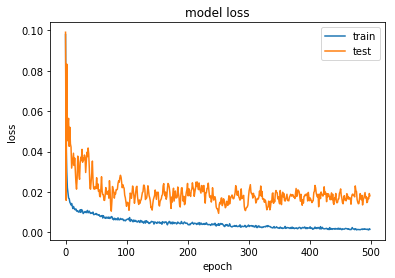

In [8]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [9]:
count = len(test_input)
sc = MinMaxScaler()
output_prices = []

for i in range(count):
    test = test_data_append[i:i+input_days, :1]
    test = sc.getScalerData(test, offset=offset)
    output = model.predict(np.expand_dims(test, axis=0))
    output_prices.append(np.squeeze(sc.getInverseData(output), axis=0))
output_prices = np.asarray(output_prices)
print(output_prices.shape, output_prices)

(20, 1) [[768.5116 ]
 [763.1144 ]
 [765.70746]
 [767.95544]
 [773.94775]
 [781.3242 ]
 [796.77856]
 [805.3854 ]
 [799.8428 ]
 [795.601  ]
 [792.00574]
 [786.33624]
 [776.34796]
 [775.22394]
 [784.71106]
 [798.9832 ]
 [804.40344]
 [812.47766]
 [809.90125]
 [799.898  ]]


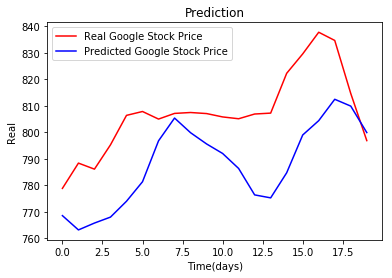

In [10]:
# Visualising the results
plt.plot(test_data_t[:, 0], color = 'red', label = 'Real Google Stock Price')
plt.plot(output_prices[:, 0], color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()